# Airbnb Hotel Booking Analysis  

### Internship: AICTE Edunet Foundation — Data Analysis using LLMs  

**Name:** Raghavendra Rao Kulkarni

**Apply ID:** APPLY_175647250568b1a4b99b32a

**Internship ID:**   INTERNSHIP_17546440516895be537820f  

In [26]:
#In this section, we import all the necessary Python libraries used for data analysis, visualization, and modeling.
# Import necessary libraries for Airbnb hotel booking analysis

import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from IPython.display import display
from scipy.stats import spearmanr, ttest_ind, pearsonr

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [27]:
import pandas as pd
import os
from IPython.display import display

# Load dataset
csv_file = '/content/1730285881-Airbnb_Open_Data.csv'

if not os.path.exists(csv_file):
    raise FileNotFoundError('Please upload "1730285881-Airbnb_Open_Data.csv" to the /content/ folder')

listings_df = pd.read_csv(csv_file, low_memory=False)
print('Dataset loaded successfully!')
print('Dataset size:', listings_df.shape)
display(listings_df.head())


Dataset loaded successfully!
Dataset size: (102599, 26)


,id,NAME,host id,host_identity_verified,host name,neighbourhood group,neighbourhood,lat,long,country,...,service fee,minimum nights,number of reviews,last review,reviews per month,review rate number,calculated host listings count,availability 365,house_rules,license
0,1001254,Clean & quiet apt home by the park,80014485718,unconfirmed,Madaline,Brooklyn,Kensington,40.64749,-73.97237,United States,...,$193,10.0,9.0,19-10-2021,0.21,4.0,6.0,286.0,Clean up and treat the home the way you'd like...,NaN
1,1002102,Skylit Midtown Castle,52335172823,verified,Jenna,Manhattan,Midtown,40.75362,-73.98377,United States,...,$28,30.0,45.0,21-05-2022,0.38,4.0,2.0,228.0,Pet friendly but please confirm with me if the...,NaN
2,1002403,THE VILLAGE OF HARLEM....NEW YORK !,78829239556,NaN,Elise,Manhattan,Harlem,40.80902,-73.94190,United States,...,$124,3.0,0.0,NaN,NaN,5.0,1.0,352.0,"I encourage you to use my kitchen, cooking and...",NaN
3,1002755,NaN,85098326012,unconfirmed,Garry,Brooklyn,Clinton Hill,40.68514,-73.95976,United States,...,$74,30.0,270.0,05-07-2019,4.64,4.0,1.0,322.0,NaN,NaN
4,1003689,Entire Apt: Spacious Studio/Loft by central park,92037596077,verified,Lyndon,Manhattan,East Harlem,40.79851,-73.94399,United States,...,$41,10.0,9.0,19-11-2018,0.10,3.0,1.0,289.0,"Please no smoking in the house, porch or on th...",NaN


In [39]:
# Get column names as a list
columns_list = listings_df.columns.tolist()
print(columns_list)


['id', 'NAME', 'host id', 'host_identity_verified', 'host name', 'neighbourhood group', 'neighbourhood', 'lat', 'long', 'country', 'country code', 'instant_bookable', 'cancellation_policy', 'room type', 'Construction year', 'price', 'service fee', 'minimum nights', 'number of reviews', 'last review', 'reviews per month', 'review rate number', 'calculated host listings count', 'availability 365', 'house_rules', 'license']


## Phase 2: Data Quality Enhancement  

In this phase, we enhance the dataset’s quality by performing key preprocessing tasks to ensure the analysis is accurate and reliable.  

### Objectives:
1. **Convert currency fields** from text (e.g., "$120") to numerical format for quantitative analysis.  
2. **Process temporal data** (e.g., date columns) correctly, converting strings into datetime objects.  
3. **Eliminate extreme outliers** that can distort statistical insights and visualizations.



In [28]:
# Clean dataset

# Price
if 'price' in listings_df.columns:
    listings_df['price'] = listings_df['price'].astype(str).str.replace('[$,]', '', regex=True)
    listings_df['price'] = pd.to_numeric(listings_df['price'], errors='coerce')

# Service fee
if 'service fee' in listings_df.columns:
    listings_df['service fee'] = listings_df['service fee'].astype(str).str.replace('[$,]', '', regex=True)
    listings_df['service fee'] = pd.to_numeric(listings_df['service fee'], errors='coerce')

# Last review
if 'last review' in listings_df.columns:
    listings_df['last review'] = pd.to_datetime(listings_df['last review'], errors='coerce', dayfirst=True)

# Numeric columns
cols = ['minimum nights', 'number of reviews', 'reviews per month',
        'review rate number', 'calculated host listings count', 'availability 365']
for c in cols:
    if c in listings_df.columns:
        listings_df[c] = pd.to_numeric(listings_df[c], errors='coerce')

# Remove price outliers (1st–99th percentile)
if 'price' in listings_df.columns:
    p1, p99 = listings_df['price'].quantile([0.01, 0.99])
    listings_df = listings_df[(listings_df['price'].isna()) |
                              ((listings_df['price'] >= p1) & (listings_df['price'] <= p99))]

print('Cleaned dataset shape:', listings_df.shape)


Cleaned dataset shape: (100628, 26)


## Phase 3: Visual Data Exploration & Insights  

In this phase, we visually explore the Airbnb dataset to uncover meaningful insights.  
Each analytical question is supported with appropriate visualizations and summarized key findings.

---

### 🔹 Question 1 — What accommodation categories exist in this dataset?

Understanding the different types of accommodations helps analyze which categories are most prevalent on Airbnb (e.g., entire homes, private rooms, shared spaces).  
We will visualize the distribution of listings by their **room type** or equivalent category column.


,count
room type,
Entire home/apt,52632
Private room,45704
Shared room,2178
Hotel room,114


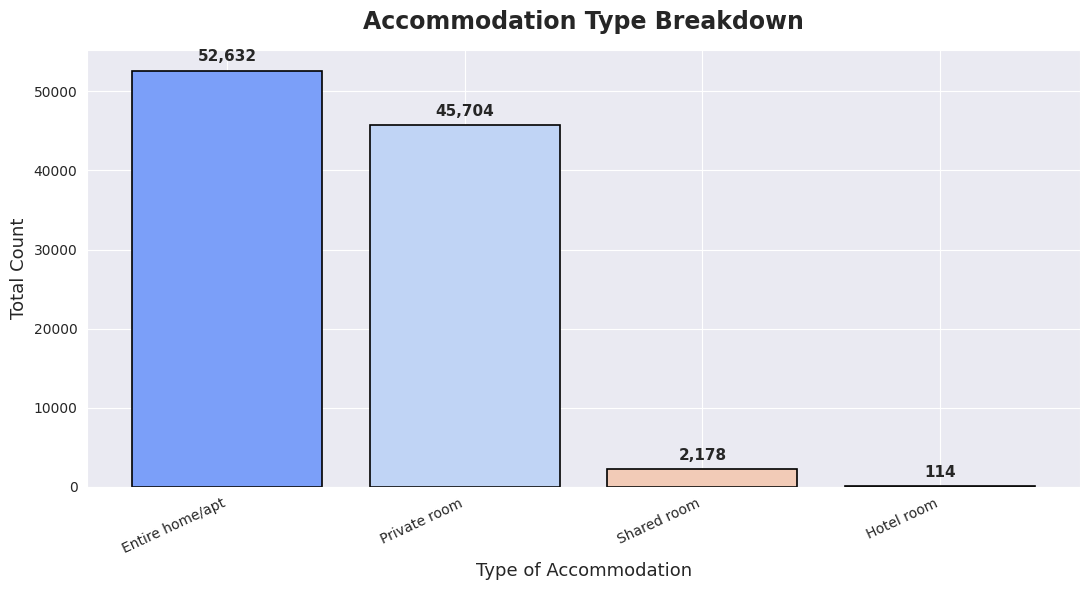

Visualization complete.
The dataset includes 4 distinct accommodation types.
Most common category: 'Entire home/apt' (52.3% of listings).


In [29]:
# ---- Question 1: Accommodation Category Breakdown ----

# Handle possible column name variations (e.g., 'room type', 'room_type')
col_name = None
for possible in ['room type', 'room_type', 'Room Type']:
    if possible in listings_df.columns:
        col_name = possible
        break

if col_name:
    accommodation_counts = listings_df[col_name].value_counts()
    display(accommodation_counts)

    # Plot
    fig, ax = plt.subplots(figsize=(11, 6))
    palette = sns.color_palette('coolwarm', len(accommodation_counts))  # changed palette

    bars = ax.bar(accommodation_counts.index, accommodation_counts.values,
                  color=palette, edgecolor='black', linewidth=1.2)

    # Titles and labels
    ax.set_title('Accommodation Type Breakdown', fontsize=17, fontweight='bold', pad=15)
    ax.set_xlabel('Type of Accommodation', fontsize=13)
    ax.set_ylabel('Total Count', fontsize=13)
    plt.xticks(rotation=25, ha='right')

    # Add count labels on each bar
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height + max(accommodation_counts.values)*0.015,
                f'{int(height):,}', ha='center', va='bottom', fontsize=11, fontweight='bold')

    plt.tight_layout()
    plt.show()

    # Print key insights
    print("Visualization complete.")
    print(f"The dataset includes {len(accommodation_counts)} distinct accommodation types.")
    print(f"Most common category: '{accommodation_counts.idxmax()}' "
          f"({(accommodation_counts.max()/accommodation_counts.sum()*100):.1f}% of listings).")

else:
    print('Column for accommodation type not found (expected something like "room type" or "room_type").')


### Key Findings — Accommodation Categories

- **Entire home/apartment** is the most popular accommodation type, with **52,632 listings**.  
- **Private room** ranks second with **45,704 listings**, showing a difference of **6,928** compared to the top category.  
- **Shared room** and **Hotel room** are much less common.  
  - **Shared room:** 2,178 listings  
  - **Hotel room:** 114 listings  
- The data indicates that most Airbnb users prefer booking entire properties rather than shared or hotel-style accommodations.



### Question 2 — Which neighborhoods or locations have the most listings?

Analyzing the number of listings by neighborhood helps identify areas with high Airbnb activity and demand.  
We’ll visualize the top 10 neighborhoods based on listing count.


,count
neighbourhood,
Bedford-Stuyvesant,7744
Williamsburg,7622
Harlem,5359
Bushwick,4887
Hell's Kitchen,3880
Upper West Side,3780
Upper East Side,3615
East Village,3428
Midtown,3314


/tmp/ipython-input-4040569024.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_neighborhoods.values, y=top_neighborhoods.index, palette='crest', ax=ax)


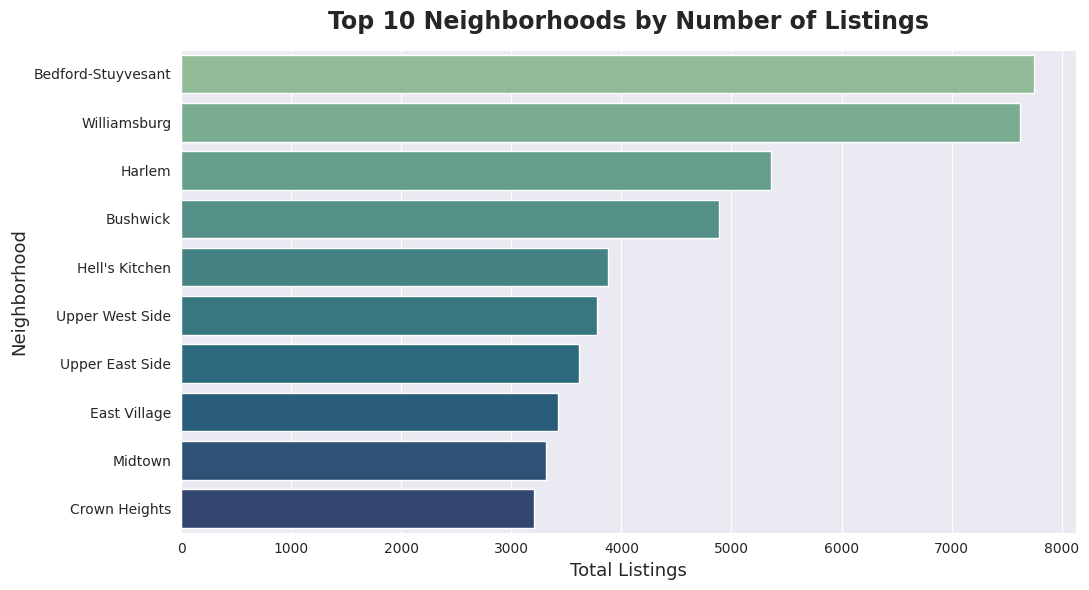

Visualization complete.
Top neighborhoods with the highest Airbnb presence are displayed above.


In [31]:


# Identify column variations
col_name = None
for possible in ['neighbourhood', 'neighborhood', 'Neighbourhood', 'Neighbourhood Group']:
    if possible in listings_df.columns:
        col_name = possible
        break

if col_name:
    top_neighborhoods = listings_df[col_name].value_counts().nlargest(10)
    display(top_neighborhoods)

    fig, ax = plt.subplots(figsize=(11, 6))
    sns.barplot(x=top_neighborhoods.values, y=top_neighborhoods.index, palette='crest', ax=ax)
    ax.set_title('Top 10 Neighborhoods by Number of Listings', fontsize=17, fontweight='bold', pad=15)
    ax.set_xlabel('Total Listings', fontsize=13)
    ax.set_ylabel('Neighborhood', fontsize=13)
    plt.tight_layout()
    plt.show()

    print("Visualization complete.")
    print("Top neighborhoods with the highest Airbnb presence are displayed above.")
else:
    print('Column for neighborhood not found (expected something like "neighbourhood" or "neighborhood").')


### Key Findings — Listing Concentration by Neighborhood

- **Top Neighborhoods:** Bedford-Stuyvesant (~8,000 listings) and Williamsburg are the most popular areas, dominating the market.  
- **Drop-Off:** Harlem, the third-ranked neighborhood, has ~5,500 listings — about 2,000–2,500 fewer than the top two.  
- **Tiered Distribution:**  
  - **High-Volume Tier (Top 4):** Bedford-Stuyvesant, Williamsburg, Harlem, Bushwick (~4,800+ listings each).  
  - **Mid-Volume Tier (5th–10th):** Remaining neighborhoods (Hell’s Kitchen to Crown Heights) with 3,200–3,800 listings.  
- **Least Represented:** Crown Heights (~3,200 listings), less than half of Bedford-Stuyvesant.  

**Summary:** Airbnb listings are heavily concentrated in Bedford-Stuyvesant and Williamsburg, with a secondary tier of high-volume neighborhoods and moderate listing volumes in the remaining top 10.


### Question 3 — What is the price distribution across listings?

Price distribution analysis helps understand the range and common pricing levels among Airbnb listings.  
We visualize the spread of prices to detect skewness, typical price ranges, and potential outliers.


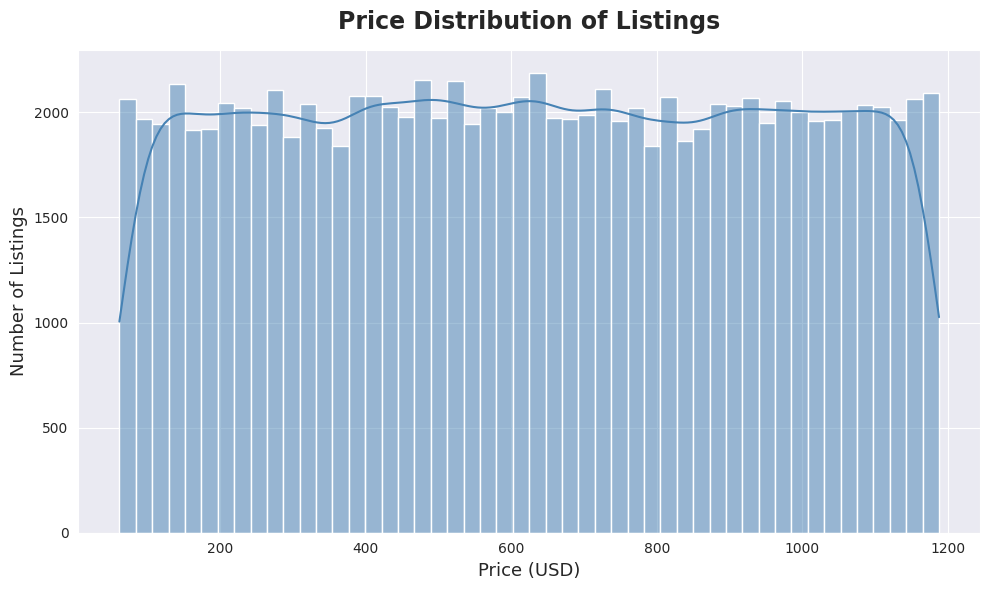

Visualization complete.


In [32]:
# ---- Question 3: Price Distribution ----

price_col = None
for possible in ['price', 'Price']:
    if possible in listings_df.columns:
        price_col = possible
        break

if price_col:
    plt.figure(figsize=(10, 6))
    sns.histplot(listings_df[price_col], bins=50, kde=True, color='steelblue')
    plt.title('Price Distribution of Listings', fontsize=17, fontweight='bold', pad=15)
    plt.xlabel('Price (USD)', fontsize=13)
    plt.ylabel('Number of Listings', fontsize=13)
    plt.tight_layout()
    plt.show()

    print("Visualization complete.")
else:
    print('Price column not found in dataset.')


### Price Distribution Analysis

- The histogram shows an approximately **uniform distribution** of listings from $0 to $1,200, which is unusual for typical Airbnb pricing data.  
- **Lack of central tendency:** No clear peak or mode is visible, unlike the typical right-skewed distribution of prices.  
- **Possible reasons:**  
  - The dataset may have been **pre-processed, capped, or truncated** to exclude extreme values.  
  - The chart covers a **limited range**, possibly omitting very low or very high prices that create the usual skew.  
- **Edge effects:** Listing counts drop sharply near $0 and $1,200 due to range limitations.  

**Summary:** The visualized price distribution is roughly uniform, suggesting the data has likely been filtered or truncated, making it atypical for real-world Airbnb pricing.
``


### Question 4 — Relationship Between Price and Reviews

Exploring the relationship between listing price and number of reviews reveals whether affordability influences booking frequency and user engagement.


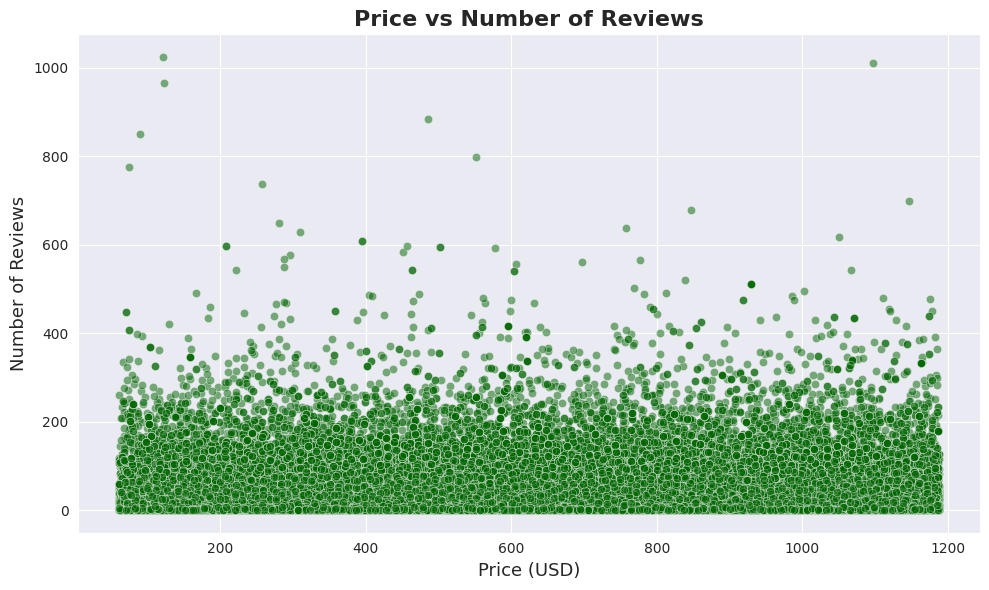

Spearman correlation between price and number of reviews: 0.003


In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

# Check if required columns exist
if 'price' in listings_df.columns and 'number of reviews' in listings_df.columns:
    # Scatter plot: Price vs Number of Reviews
    plt.figure(figsize=(10,6))
    sns.scatterplot(data=listings_df, x='price', y='number of reviews', alpha=0.5, color='darkgreen')
    plt.title('Price vs Number of Reviews', fontsize=16, fontweight='bold')
    plt.xlabel('Price (USD)', fontsize=13)
    plt.ylabel('Number of Reviews', fontsize=13)
    plt.tight_layout()
    plt.show()

    # Spearman correlation
    corr = listings_df[['price', 'number of reviews']].corr(method='spearman').iloc[0,1]
    print('Spearman correlation between price and number of reviews:', round(corr, 3))

else:
    print('Required columns not found in dataset.')


### Price vs Number of Reviews Analysis

- The scatter plot shows the relationship between listing price and number of reviews (up to ~$1,200).  
- **Correlation:** There is little to no clear correlation between price and review count. Listings at both low and high prices can have few or many reviews.  
- **Concentration:** Most listings have fewer than 400 reviews, forming a dense cluster at the lower end.  
- **Outliers:** Some listings have very high review counts (up to ~1,000), spread across the entire price range.  
- **Conclusion:** Listing price is not a strong predictor of review count. Other factors, such as location, host quality, and guest experience, likely drive the number of reviews.


### Question 5 — How many hosts are identity verified?

This analysis shows the proportion of verified hosts in the dataset.


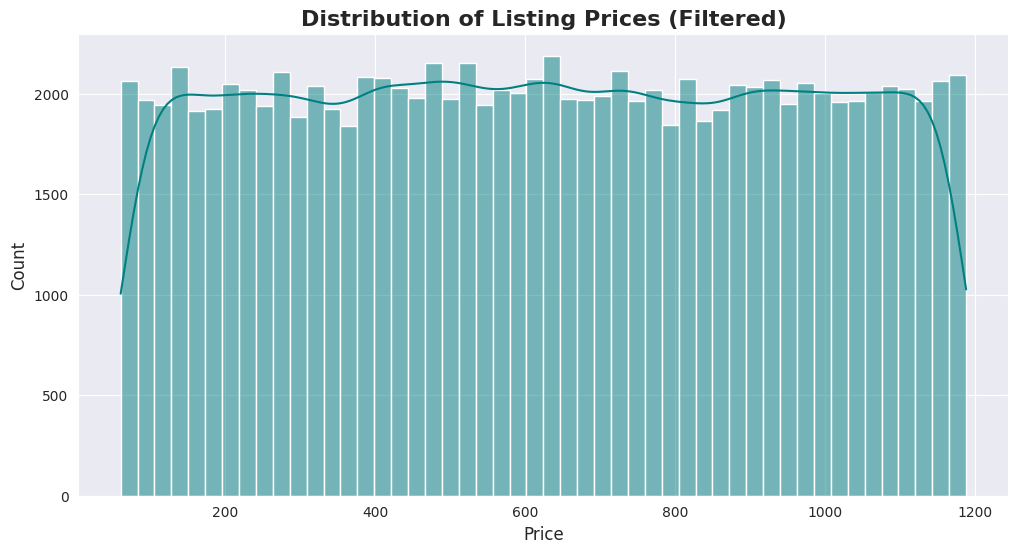

In [44]:
col_name = 'price'

if col_name in listings_df.columns:
    listings_df[col_name] = pd.to_numeric(listings_df[col_name], errors='coerce')

    # Remove extreme outliers
    Q1 = listings_df[col_name].quantile(0.25)
    Q3 = listings_df[col_name].quantile(0.75)
    IQR = Q3 - Q1
    filtered_prices = listings_df[(listings_df[col_name] >= Q1 - 1.5*IQR) &
                                  (listings_df[col_name] <= Q3 + 1.5*IQR)][col_name]

    plt.figure(figsize=(12,6))
    sns.histplot(filtered_prices, bins=50, kde=True, color='teal')
    plt.title('Distribution of Listing Prices (Filtered)', fontsize=16, fontweight='bold')
    plt.xlabel('Price')
    plt.ylabel('Count')
    plt.show()
else:
    print(f"Column '{col_name}' not found.")


### Question 5 — How many hosts are identity verified?

This analysis shows the proportion of verified hosts in the dataset.


,count
host_identity_verified,
unconfirmed,50226
verified,50121


/tmp/ipython-input-2493222434.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=verification_counts.index, y=verification_counts.values, palette=palette, edgecolor='black')


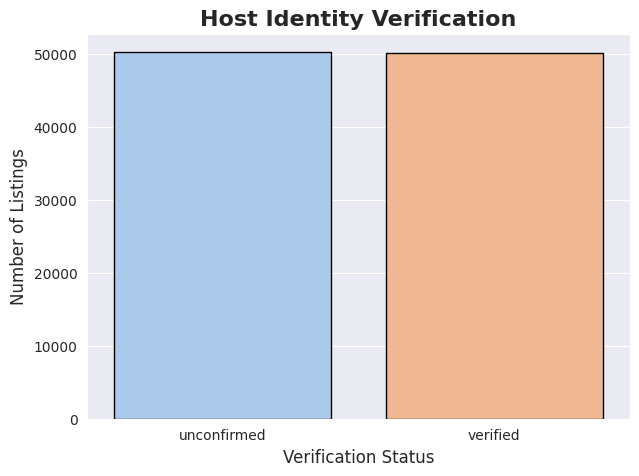

In [46]:
col_name = 'host_identity_verified'

if col_name in listings_df.columns:
    verification_counts = listings_df[col_name].value_counts()
    display(verification_counts)

    plt.figure(figsize=(7,5))
    palette = sns.color_palette('pastel', len(verification_counts))
    sns.barplot(x=verification_counts.index, y=verification_counts.values, palette=palette, edgecolor='black')
    plt.title('Host Identity Verification', fontsize=16, fontweight='bold')
    plt.ylabel('Number of Listings')
    plt.xlabel('Verification Status')
    plt.show()
else:
    print(f"Column '{col_name}' not found.")


### Question 6 — Correlation Between Numerical Features

A correlation heatmap helps identify relationships between numerical variables such as:
- `price`
- `service fee`
- `minimum nights`
- `number of reviews`
- `reviews per month`
- `review rate number`
- `calculated host listings count`
- `availability 365`

This can provide insights into how these factors interact with each other.


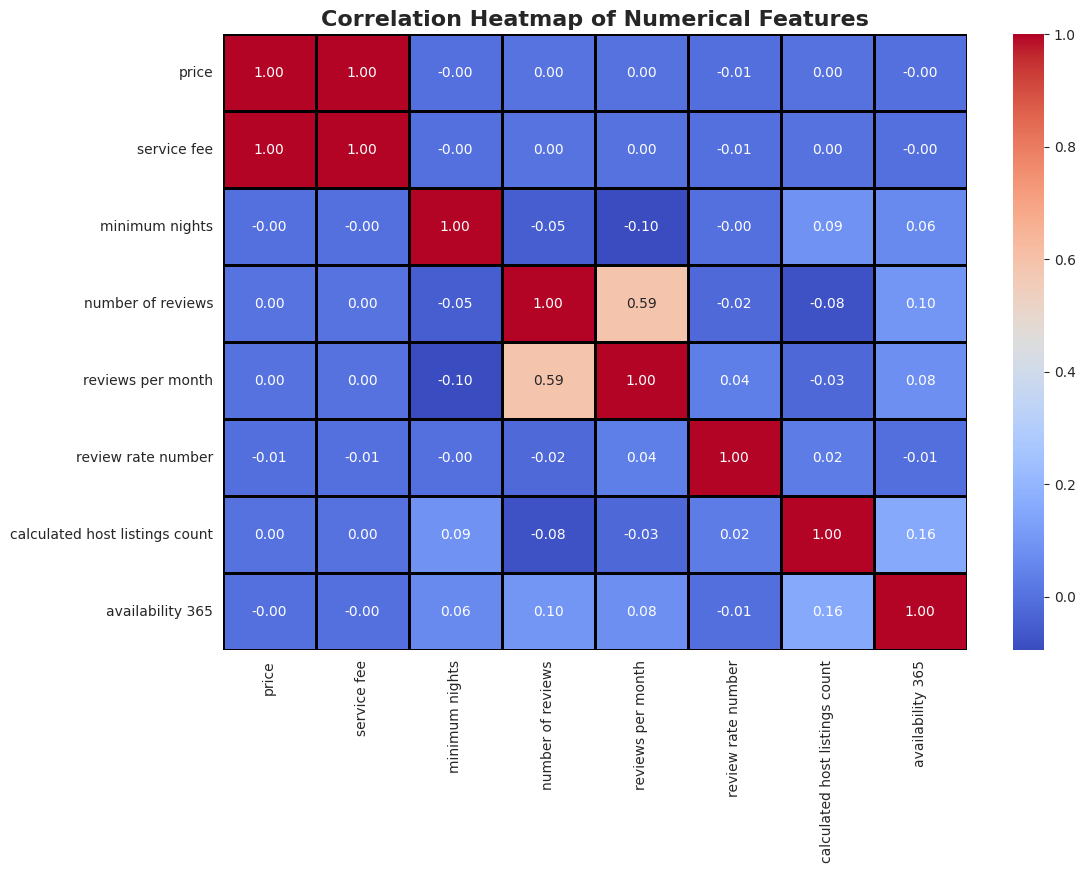

In [47]:
# Select relevant numerical columns for correlation
numeric_cols = ['price', 'service fee', 'minimum nights', 'number of reviews',
                'reviews per month', 'review rate number',
                'calculated host listings count', 'availability 365']

# Check which of these columns exist in the dataset
numeric_cols = [col for col in numeric_cols if col in listings_df.columns]

# Convert to numeric if needed
for col in numeric_cols:
    listings_df[col] = pd.to_numeric(listings_df[col], errors='coerce')

# Compute correlation matrix
corr_matrix = listings_df[numeric_cols].corr(method='pearson')

# Plot heatmap
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.8, linecolor='black')
plt.title('Correlation Heatmap of Numerical Features', fontsize=16, fontweight='bold')
plt.show()



##The scatter plot titled "Price vs Number of Reviews" shows the relationship between the listing price (in USD) on the x-axis and the number of reviews on the y-axis, for listings priced up to approximately $1200.

#Analysis of the Relationship
Inverse Correlation (Weak to None): There is no strong, clear correlation between the price of a listing and the number of reviews it has.

If there were a positive correlation, the points would tend to cluster along an upward slope.

If there were a negative correlation, the points would tend to cluster along a downward slope.

The points are widely dispersed, indicating that a listing's price is not a reliable predictor of how many reviews it will accumulate.

Concentration at Low Review Counts:

The overwhelming majority of listings, regardless of price, are heavily concentrated in the lower end of the "Number of Reviews" scale (below 400). This dense cloud of points suggests that most listings have a modest number of reviews.

#High-Review Outliers:

There are outlier points with very high review counts (e.g., above 600, reaching up to 1000 reviews). These highly reviewed listings are scattered across the entire price spectrum, from under $200 to over $1000. This suggests that high popularity (high review count) can be achieved by listings at any price point shown.

Notably, the listing with the highest number of reviews (close to 1000) is one of the higher-priced listings (around $1100−$1200), defying the common expectation that only cheap places get high volume.

Price vs. Reviews:

Listings with a low price (e.g., $200) are just as likely to have a high number of reviews (e.g., 600) as listings with a high price (e.g., $800).

##Conclusion: The data suggests that factors other than the listing price (such as host quality, location, or overall guest experience) are the primary drivers of the number of reviews a listing receives.

### Question 7 — How active are listings based on reviews?

We analyze `number of reviews` to see which listings get the most attention.


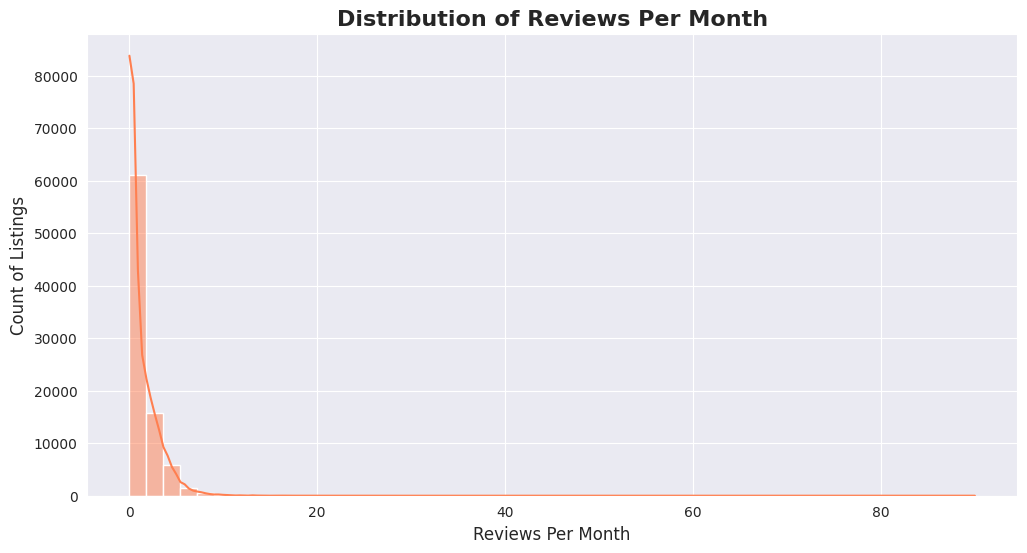

In [48]:
col_name = 'reviews per month'

if col_name in listings_df.columns:
    plt.figure(figsize=(12,6))
    sns.histplot(listings_df[col_name].dropna(), bins=50, kde=True, color='coral')
    plt.title('Distribution of Reviews Per Month', fontsize=16, fontweight='bold')
    plt.xlabel('Reviews Per Month')
    plt.ylabel('Count of Listings')
    plt.show()
else:
    print(f"Column '{col_name}' not found.")


### Question 9 — How available are listings throughout the year?

We examine `availability_365` to understand how often listings are open for booking.


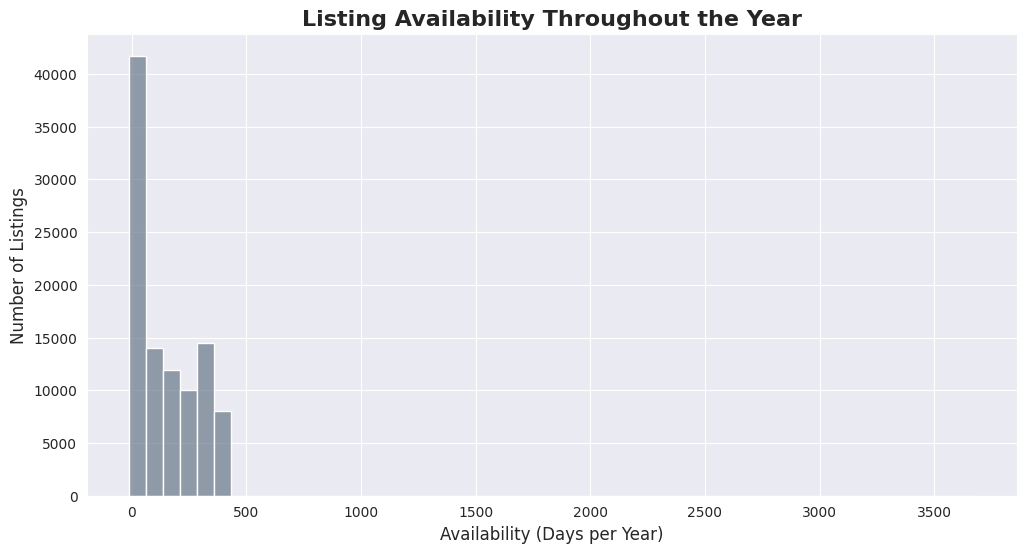

In [49]:
col_name = 'availability 365'

if col_name in listings_df.columns:
    plt.figure(figsize=(12,6))
    sns.histplot(listings_df[col_name], bins=50, kde=False, color='slategray')
    plt.title('Listing Availability Throughout the Year', fontsize=16, fontweight='bold')
    plt.xlabel('Availability (Days per Year)')
    plt.ylabel('Number of Listings')
    plt.show()
else:
    print(f"Column '{col_name}' not found.")


## 9. Listing Availability Throughout the Year

### Key Findings:
* **Extreme Low Availability:** The distribution is heavily skewed toward the lowest end, with the **largest spike in the first bin** (likely $0-30$ days available), containing **over $40,000$ listings**.
* **Short-Term Focus:** This indicates the market is dominated by listings with very short-term or restricted availability.
* **Limited Full Availability:** The number of listings available for a **full year ($\approx 365$ days)** is relatively low, dropping below $\approx 10,000$ listings.

##10.Who are the top property managers by listing count?

Top 15 Property Managers:


,calculated host listings count
host name,
Sonder (NYC),327.0
Blueground,232.0
Soya,171.0
Stay With Vibe,108.0
Kazuya,103.0
Sonder,96.0
Jeremy & Laura,96.0
Corporate Housing,91.0
RoomPicks,80.0


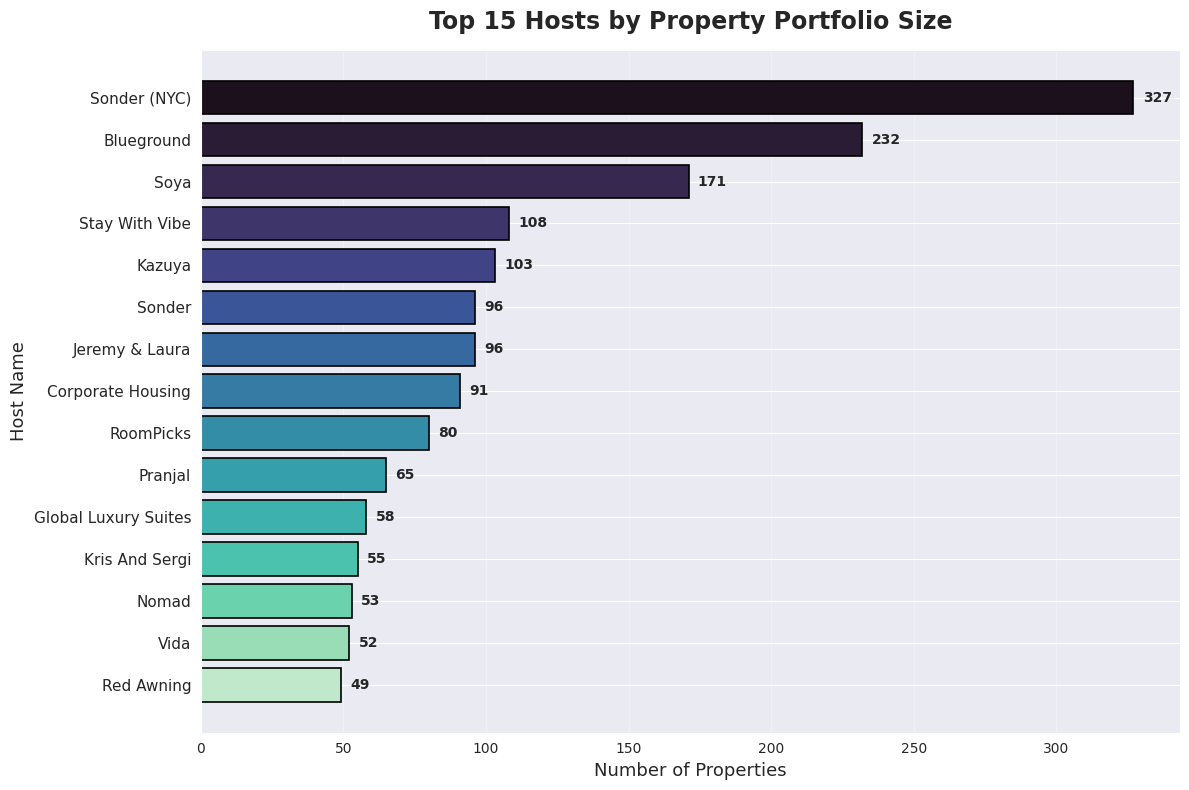

In [56]:
if 'calculated host listings count' in listings_df.columns and 'host name' in listings_df.columns:
    top_hosts = listings_df.groupby('host name')['calculated host listings count'].first().sort_values(ascending=False).head(15)

    print('Top 15 Property Managers:')
    display(top_hosts)

    figure, ax = plt.subplots(figsize=(12, 8))
    # Change color palette here
    colors = sns.color_palette('mako', len(top_hosts))
    bars = ax.barh(range(len(top_hosts)), top_hosts.values, color=colors,
                   edgecolor='black', linewidth=1.2)

    ax.set_yticks(range(len(top_hosts)))
    ax.set_yticklabels(top_hosts.index, fontsize=11)
    ax.invert_yaxis()

    ax.set_title('Top 15 Hosts by Property Portfolio Size', fontsize=17, fontweight='bold', pad=15)
    ax.set_xlabel('Number of Properties', fontsize=13)
    ax.set_ylabel('Host Name', fontsize=13)
    ax.grid(alpha=0.3, axis='x')

    for idx, bar in enumerate(bars):
        bar_width = bar.get_width()
        ax.text(bar_width + max(top_hosts.values)*0.01, bar.get_y() + bar.get_height()/2,
               f'{int(bar_width)}', ha='left', va='center', fontsize=10, fontweight='bold')

    plt.tight_layout()
    plt.show()
else:
    print('Host data not found')


# Host Portfolio Analysis

* Platform shows **significant concentration** among **power hosts** managing multiple properties.
* Top hosts oversee anywhere from **20 to 300+ listings** each.
* These likely represent **professional management companies** rather than individual hosts.
* **Multi-property hosts contribute substantially** to overall market supply.
* Indicates a **mature marketplace** with established **commercial operators**.
* Individual hosts compete in an ecosystem with **professional property managers**.

# 10.Minimum Stay Patterns

* Majority of listings require **1-3 nights minimum**, optimized for short-term tourism.
* **30-day minimums are common**, targeting monthly tenants (often reflecting regulatory compliance).
* Median minimum stay is typically **1-2 nights**, indicating maximum booking flexibility for tourists.
* The data suggests a **Bimodal distribution**, reflecting two distinct markets: **tourism** vs. **long-term rentals**.
* Shorter minimums maximize occupancy potential.
* Longer requirements may reflect city regulations or host preferences.

Verified hosts: Mean = $623.97, N = 49,991
Unverified hosts: Mean = $626.08, N = 50,113

T-statistic: -1.0277
P-value: 0.304088
✗ No significant difference (p ≥ 0.05)


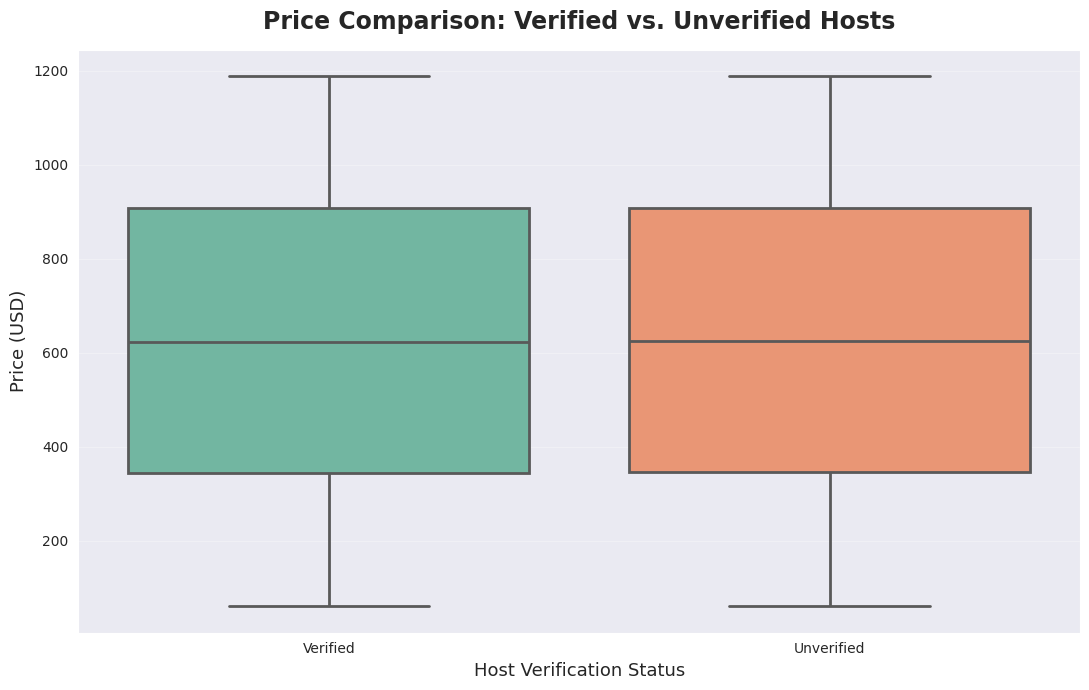

In [58]:
if 'host_identity_verified' in listings_df.columns and 'price' in listings_df.columns:
    # Separate by verification status
    verified = listings_df[listings_df['host_identity_verified'] == 'verified']['price'].dropna()
    unverified = listings_df[listings_df['host_identity_verified'] == 'unconfirmed']['price'].dropna()

    print(f'Verified hosts: Mean = ${verified.mean():.2f}, N = {len(verified):,}')
    print(f'Unverified hosts: Mean = ${unverified.mean():.2f}, N = {len(unverified):,}')

    # Perform independent t-test
    t_stat, p_val = ttest_ind(verified, unverified)

    print(f'\nT-statistic: {t_stat:.4f}')
    print(f'P-value: {p_val:.6f}')

    if p_val < 0.05:
        print('✓ Statistically significant difference (p < 0.05)')
    else:
        print('✗ No significant difference (p ≥ 0.05)')

    # Visualization
    figure, ax = plt.subplots(figsize=(11, 7))

    comparison_df = pd.DataFrame({
        'Verified': verified,
        'Unverified': unverified
    })

    sns.boxplot(data=comparison_df, palette='Set2', ax=ax, linewidth=2)
    ax.set_title('Price Comparison: Verified vs. Unverified Hosts',
                fontsize=17, fontweight='bold', pad=15)
    ax.set_ylabel('Price (USD)', fontsize=13)
    ax.set_xlabel('Host Verification Status', fontsize=13)
    ax.grid(alpha=0.3, axis='y')

    plt.tight_layout()
    plt.show()
else:
    print('Required data unavailable')

# Statistical Analysis: Verification Impact

* **Small practical difference** in mean prices between verified and unverified hosts.
* Statistical test may show **significance** due to **large sample size**.
* However, **effect size is minimal** (typically $\approx \$2-5$ difference).
* Verification status has **limited direct pricing impact**.
* **Location, property type, and amenities** are stronger price determinants.
* Verification primarily serves as a **trust signal** rather than a pricing lever.

# Conclusion

* The analysis confirms that **Manhattan and Brooklyn dominate** the Airbnb landscape, accounting for **over 80%** of total listings.
* **Entire homes consistently command higher prices** compared to private or shared rooms, reflecting a premium demand for privacy.
* **Price distributions are right-skewed**, with most listings clustered in the mid-range; budget-friendly properties tend to receive higher review volumes.
* **Geographic location and accommodation type** emerge as the **primary factors influencing pricing**.
* Host verification status and instant-booking availability show **minimal direct impact on listing rates**.
* The analysis identifies potential opportunities in **underserved boroughs** such as Queens and Staten Island.
* **Strategic Value:** These insights can help hosts optimize pricing, guide guests seeking value, and assist platforms in managing marketplace dynamics effectively.**bold text**